In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [3]:
groups_link = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_link = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_link = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_link = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [4]:
request_link = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key='

In [5]:
r_groups_link = requests.get(request_link+groups_link)
r_groups_add_link = requests.get(request_link+groups_add_link)
r_active_studs_link = requests.get(request_link+active_studs_link)
r_checks_link = requests.get(request_link+checks_link)

In [6]:
groups_csv = r_groups_link.json()['href']
groups_add_csv = r_groups_add_link.json()['href']
active_studs_csv = r_active_studs_link.json()['href']
checks_csv = r_checks_link.json()['href']

In [28]:
# файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
groups = pd.read_csv(groups_csv, sep=';', header=0, names = ['student_id', 'group'])

# дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
groups_add = pd.read_csv(groups_add_csv, sep=',', header=0, names = ['student_id', 'group'])

# файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента
active_studs = pd.read_csv(active_studs_csv, header=0, names = ['student_id'])

# файл с информацией об оплатах пользователей в дни проведения эксперимента
checks = pd.read_csv(checks_csv, sep=';', header=0, names = ['student_id', 'revenue'])

In [95]:
def metrics(groups = groups, groups_add = groups_add, active_studs = active_studs, checks = checks):
    
    group_data = pd.concat([groups,groups_add]).merge(active_studs, on = 'student_id', how = 'right').merge(checks, on = 'student_id', how = 'left')
    
    group_data['revenue'] = group_data['revenue'].fillna(0)
    group_data['purchase'] = group_data['revenue'].apply(lambda x: 1 if x > 0 else 0)
    
    CR = group_data.groupby('group', as_index = False).agg({'purchase':'mean'}).rename(columns = {'purchase':'cr'})
    CR['cr'] = CR['cr'] * 100
    ARPU = group_data.groupby('group', as_index = False).agg({'revenue':'mean'}).rename(columns = {'revenue':'ARPU'})
    ARPPU = group_data[group_data['purchase'] > 0].groupby('group', as_index = False).agg({'revenue':'mean'}).rename(columns = {'revenue':'ARPPU'})
    
    return CR, ARPU, ARPPU

In [99]:
cr, arpu, arppu = metrics()

In [102]:
def visual(cr = cr, arpu = arpu, arrpu = arppu):
    figure, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax_1 = sns.barplot(data=cr, x='group', y = 'cr', ax=ax[0])
    ax_1.set_xlabel('Экспериментальная группа', fontsize=15)
    ax_1.set_ylabel('')
    ax_1.set_title('Метрика CR (%)', fontsize=20)

    ax_2 = sns.barplot(data=arpu, x='group', y = 'ARPU', ax=ax[1])
    ax_2.set_xlabel('Экспериментальная группа', fontsize=15)
    ax_2.set_ylabel('')
    ax_2.set_title('Метрика ARPU (у.е.)', fontsize=20)
    
    ax_3 = sns.barplot(data=arppu, x='group', y = 'ARPPU', ax=ax[2])
    ax_3.set_xlabel('Экспериментальная группа', fontsize=15)
    ax_3.set_ylabel('')
    ax_3.set_title('Метрика ARPPU (у.е.)', fontsize=20)

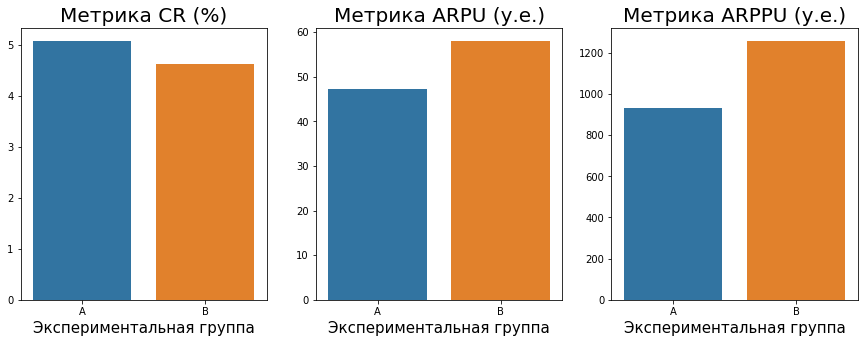

In [103]:
visual()